In [154]:
#DTW calculation

import pandas as pd
import numpy as np
import os
import glob 
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances

%matplotlib inline

In [155]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [156]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1

In [157]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [158]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
    
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        if( len(df) > len(complexs)):
            complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
            
        df[output_features[i]] = complexs
    return df

In [246]:
def data_preprocessing(df):
#     df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 5
    df = GaussianFilter(df, 10)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df
    
    
    
    
    

In [303]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gz = df['GZ'].values[i: i + N_TIME_STEPS]
#         gy = df['AZ'].values[i: i + N_TIME_STEPS]   
        label = "ST"
        segments.append([gz])
#         labels = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        labels.append(label)
    return segments, labels

In [304]:
def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
#     if len(x)==1:
#         path = zeros(len(y)), range(len(y))
#     elif len(y) == 1:
#         path = range(len(x)), zeros(len(x))
#     else:
#         path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1

In [305]:
def DTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [306]:
def loss_for_segments(segments, comp, dist_fun):
    loss =[]
    length = len(segments)
    for i in range(length):
        x = segments[i][0]
#         dist, cost, acc = dtw(x, y, dist_fun)
        dist = DTWDistance(x, y, 50)
        print(i , '=>', dist)
        loss.append(dist)
        
    return loss

In [307]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [308]:
# Function to map the colors as a list from the input list of x variables
def color_mapping(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [309]:
def read_files(acc_file, gyro_file, activity):
    df = read_csv_file(acc_file, gyro_file, activity)
    df.reset_index(drop = True , inplace = True)
    if('Milliseconds' in df.columns):
        df = df.drop('Milliseconds', axis=1)
    if('Timestamp' in df.columns):
        df = df.drop('Timestamp', axis=1)

    df = data_preprocessing(df)
    
    return df
    

In [310]:
  
path_acc = os.getcwd() + '/data/bike/*/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/bike/*/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df= read_files(acc_files[0], gyro_files[0], 'bike')
n = len(df)
df = df[1500:n-1000]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'bike')
    n = len(df_this)
    df_this = df_this[1500 : n-2000]
    print("len of this file ",df_this.shape)
#     print(df_this.columns)
    df = pd.concat([df, df_this])
    print(df.shape)
df.reset_index(drop = True, inplace = True)
df.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike2308/2018-08-23_16-01-56/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike2308/2018-08-23_16-01-56/Gyroscope.csv
len of this file  (9048, 15)
(19096, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike2308/2018-08-23_16-15-15/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike2308/2018-08-23_16-15-15/Gyroscope.csv
len of this file  (4101, 15)
(23197, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike2308/2018-08-23_16-18-07/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike2308/2018-08-23_16-18-07/Gyroscope.csv
len of this file  (10913, 15)
(34110, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike2308/2018-08-23_16-00-19/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/bike/Bike2308/2018-08-23_16-00-19/Gyroscope.csv
len of this file  (0, 15)
(34110, 15)
/home/vicky/De

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,0.053224,0.314816,-0.039182,-0.011374,-0.039128,-0.005193,bike,0.109619,-0.018565,-1.419633,1.155152,-0.926777,-1.419633,1.155152,-0.926777
1,0.050394,0.317808,-0.024306,-0.010242,-0.035566,-0.007808,bike,0.114632,-0.017872,0.279686,-0.158640,0.280778,0.279686,-0.158640,0.280778
2,0.047070,0.319707,-0.010741,-0.009198,-0.031665,-0.010444,bike,0.118678,-0.017102,-1.299177,0.950650,-0.962019,-1.299177,0.950650,-0.962019
3,0.043323,0.320499,0.001363,-0.008262,-0.027466,-0.013066,bike,0.121728,-0.016265,0.363979,-0.220690,0.102549,0.363979,-0.220690,0.102549
4,0.039209,0.320110,0.011780,-0.007458,-0.023013,-0.015640,bike,0.123699,-0.015370,-1.437911,1.003662,-0.826258,-1.437911,1.003662,-0.826258


In [311]:
  
path_acc = os.getcwd() + '/data/car/*/*/*AccelerometerLinear.csv'  
path_gyro= os.getcwd() + '/data/car/*/*/*Gyroscope.csv' 
acc_files = glob.glob(path_acc)
gyro_files= glob.glob(path_gyro)
df1= read_files(acc_files[0], gyro_files[0], 'car')
n = len(df1)
df1 = df1[1500:n-1000]
for acc_file, gyro_file in zip(acc_files, gyro_files) :
    print(acc_file)
    print(gyro_file)
    df_this = read_files(acc_file, gyro_file, 'car')
    n = len(df_this)
    df_this = df_this[1500 : n-2000]
    print("len of this file ",df_this.shape)
    df1 = pd.concat([df1, df_this])
    print(df1.shape)
df1.reset_index(drop = True, inplace = True)
df1.head()


/home/vicky/Desktop/Dhananjay/human-activity/data/car/Car1109out/2018-09-11_19-14-12/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car/Car1109out/2018-09-11_19-14-12/Gyroscope.csv
len of this file  (122, 15)
(1244, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/car/Car1109out/2018-09-11_18-46-25/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car/Car1109out/2018-09-11_18-46-25/Gyroscope.csv
len of this file  (2810, 15)
(4054, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/car/Car1109out/2018-09-11_18-55-22/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car/Car1109out/2018-09-11_18-55-22/Gyroscope.csv
len of this file  (0, 15)
(4054, 15)
/home/vicky/Desktop/Dhananjay/human-activity/data/car/Car1109out/2018-09-11_19-17-04/AccelerometerLinear.csv
/home/vicky/Desktop/Dhananjay/human-activity/data/car/Car1109out/2018-09-11_19-17-04/Gyroscope.csv
len of this file  (513, 15)
(4567, 15)
/home/vicky/D

,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,-0.230705,0.629849,0.025412,0.032971,0.046422,0.031496,car,0.141518,0.036963,-0.253709,-0.078774,-0.469316,-0.253709,-0.078774,-0.469316
1,-0.237297,0.639779,0.019223,0.030684,0.042978,0.031509,car,0.140568,0.035057,0.334182,0.103027,0.616717,0.334182,0.103027,0.616717
2,-0.243107,0.648608,0.013157,0.028013,0.039571,0.031699,car,0.139553,0.033095,-0.254521,-0.078132,-0.469309,-0.254521,-0.078132,-0.469309
3,-0.248168,0.656360,0.007298,0.025100,0.036283,0.032013,car,0.138496,0.031132,0.333122,0.103071,0.614661,0.333122,0.103071,0.614661
4,-0.252544,0.663094,0.001722,0.022076,0.033181,0.032396,car,0.137424,0.029218,-0.253566,-0.078275,-0.470071,-0.253566,-0.078275,-0.470071


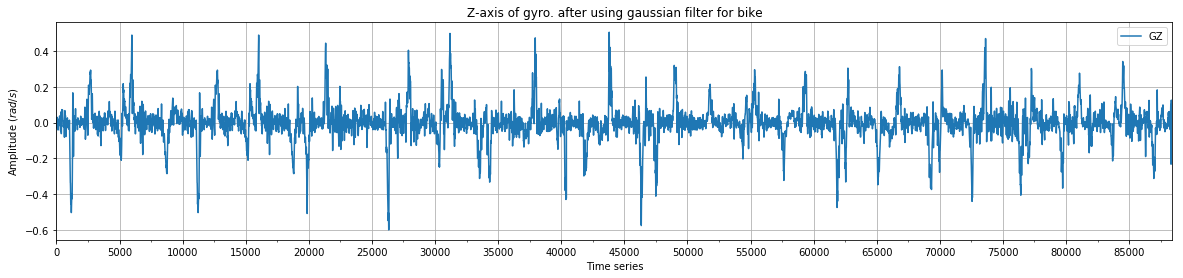

In [312]:
fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

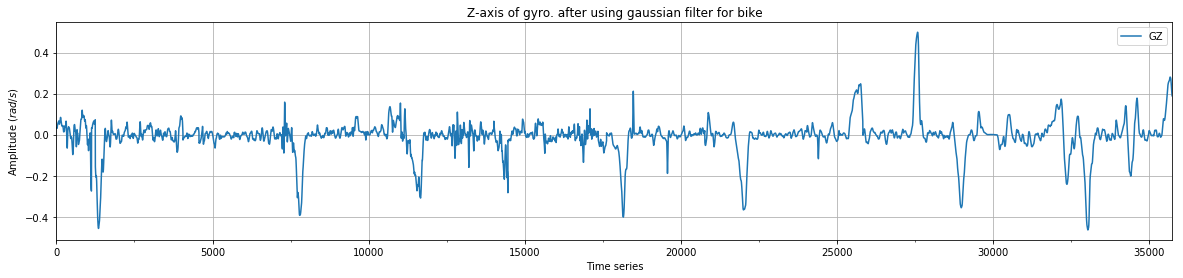

In [313]:
fig, ax = plt.subplots()
df1[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df1)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2500)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [325]:
bike_segments, bike_labels = segmentation(df, 500)
np.array(bike_segments).shape


(1759, 1, 500)

In [326]:
segments = bike_segments
labels   = ['bike']*len(segments)


In [327]:
car_segments, car_labels = segmentation(df1, 500)
np.array(car_segments).shape
print(len(car_segments))
labels1 = ['car']*len(car_segments)

706


In [328]:
for i in range(len(car_segments)):
    segments.append(car_segments[i])
labels = labels + labels1
print(len(segments))
print(len(labels))

2465
2465


In [329]:

from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
N_TIME_STEPS = 500
N_FEATURES = 1

# reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)


In [330]:
X_train, X_test, y_train, y_test = train_test_split(segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [336]:
from sklearn.metrics import classification_report

def knn(train,test,w):
    preds=[]
    for ind,i in enumerate(test):
        min_dist=float('inf')
        closest_seq=[]
        #print ind
        for j in train:
            if(DTWDistance(i[:-1],j[:-1],5)<min_dist):
                dist=DTWDistance(i[:-1],j[:-1],w)
                print(dist)
                if dist<min_dist:
                    min_dist=dist
                    closest_seq=j
        print(min_dist)
        preds.append(closest_seq[-1])
    return classification_report(y_test[:,-1],preds)

In [337]:
print(knn(X_train,X_test,50))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


ValueError: Mix type of y not allowed, got types {'binary', 'continuous-multioutput'}

In [235]:
x = bike_segments
dist_fun = manhattan_distances
y = bike_segments[10][0]
# dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
diff_wrt_LT = loss_for_segments(x, y ,dist_fun)
loss_series = pd.Series(diff_wrt_LT)
loss_series.to_csv('fiff_wrt_LT_car')

0 => 0.744943361321
1 => 0.586023331872
2 => 0.544504124486
3 => 0.469715294807
4 => 0.843019600776
5 => 0.552304528335
6 => 0.59740226943
7 => 0.655407907589
8 => 0.733871492496
9 => 0.19714973212
10 => 0.0
11 => 0.257633387813
12 => 1.50406493213
13 => 3.05292139518
14 => 4.43743906949
15 => 5.31206197454
16 => 5.50501316032
17 => 5.26044516335
18 => 5.03456873187
19 => 5.15078578038
20 => 5.36439488901
21 => 5.07544634877
22 => 5.1878067431
23 => 4.57217347556
24 => 3.33727104419
25 => 1.75697340144
26 => 0.97938774884
27 => 0.842985657406
28 => 0.573936229343
29 => 0.612117902397
30 => 0.523521731157
31 => 0.503066423161
32 => 0.604081043748
33 => 0.619900990617
34 => 0.437904616807
35 => 0.622338573239
36 => 0.689943128881
37 => 0.677974504787
38 => 0.811726655871
39 => 1.05660515707
40 => 0.862541074141
41 => 1.29344762471
42 => 1.75598257664
43 => 2.3493469876
44 => 2.90983873949
45 => 3.43565436024
46 => 3.5125253378
47 => 3.64244039209
48 => 3.51555145091
49 => 3.37223212162
5

390 => 3.98748405883
391 => 3.88474765233
392 => 3.71902540607
393 => 3.72917936395
394 => 3.75886298295
395 => 3.76995886591
396 => 3.80457914745
397 => 3.60841758611
398 => 2.27295964701
399 => 1.90830144222
400 => 1.20548806009
401 => 0.718602849615
402 => 0.465466095586
403 => 0.680683837494
404 => 0.816918481092
405 => 0.558197791006
406 => 0.488645079228
407 => 0.568903632014
408 => 0.566898963639
409 => 0.498009963242
410 => 0.478252760209
411 => 0.546281510001
412 => 0.462347364477
413 => 0.652389602729
414 => 0.83705184211
415 => 0.850169320099
416 => 1.58570388965
417 => 3.33682817198
418 => 3.94275339861
419 => 4.20863668942
420 => 4.30673877188
421 => 4.54661144607
422 => 4.43876859418
423 => 4.08797411457
424 => 4.10392060405
425 => 4.39137989941
426 => 4.138420755
427 => 3.02857753338
428 => 2.40299165667
429 => 1.6517570541
430 => 1.36496252653
431 => 1.02751732969
432 => 0.573774258425
433 => 0.851629460474
434 => 0.907760620505
435 => 0.682109015678
436 => 0.8261804633

774 => 0.357562189516
775 => 0.495142819753
776 => 0.524960408341
777 => 0.586765966265
778 => 0.38937979251
779 => 0.540917651203
780 => 0.540204106911
781 => 0.508137021527
782 => 0.596564811963
783 => 0.579363086921
784 => 0.713357704213
785 => 1.00596835963
786 => 1.00011068152
787 => 1.37294949119
788 => 1.29991927171
789 => 0.976622931681
790 => 1.21110144729
791 => 1.22322515305
792 => 1.23156974428
793 => 1.10068325492
794 => 1.12512071427
795 => 1.0940490951
796 => 1.74804453946
797 => 2.81067603982
798 => 3.95874101744
799 => 4.13024894523
800 => 4.08878160082
801 => 3.76057491499
802 => 3.60858752352
803 => 4.06946170477
804 => 3.63408354931
805 => 3.77206464159
806 => 3.94978916298
807 => 3.18199096966
808 => 1.47757714638
809 => 0.590873582799
810 => 0.319491683711
811 => 0.37297455023
812 => 0.562185737199
813 => 0.502296313006
814 => 0.501291762181
815 => 0.611749414858
816 => 0.522860516751
817 => 0.395284303095
818 => 0.4214443809
819 => 0.731177841069
820 => 0.6161504

1150 => 2.48670374261
1151 => 2.41558582387
1152 => 2.76875517823
1153 => 2.01356912442
1154 => 1.19315246135
1155 => 0.972094439305
1156 => 1.13896514058
1157 => 1.11008672449
1158 => 1.06999366585
1159 => 1.1214638414
1160 => 1.17767762958
1161 => 1.07179045285
1162 => 0.999889367967
1163 => 0.934251136399
1164 => 0.958848573772
1165 => 0.924195727618
1166 => 0.893652901601
1167 => 0.624522496152
1168 => 0.676042210863
1169 => 0.719636781625
1170 => 0.673901716952
1171 => 0.713953211063
1172 => 0.71851118039
1173 => 0.940293157406
1174 => 1.41214438551
1175 => 1.57452129535
1176 => 2.091354555
1177 => 2.77082576019
1178 => 3.1576910314
1179 => 3.37173149027
1180 => 3.19049983073
1181 => 3.38914633971
1182 => 3.37886314951
1183 => 3.00030224288
1184 => 2.83057258416
1185 => 3.10495253851
1186 => 2.73872253783
1187 => 2.10991287178
1188 => 1.50114042815
1189 => 0.554248807626
1190 => 0.731777098081
1191 => 0.640325309855
1192 => 0.57362158381
1193 => 0.594784731894
1194 => 0.7037577718

1517 => 1.98664302297
1518 => 2.97831342955
1519 => 3.74076568347
1520 => 4.11722340238
1521 => 3.95348513887
1522 => 3.84288682116
1523 => 3.90449438729
1524 => 3.93701318795
1525 => 3.84999464806
1526 => 4.01732307845
1527 => 3.63709420202
1528 => 3.07782225929
1529 => 2.06752305025
1530 => 1.78291051004
1531 => 1.63118398897
1532 => 1.95192239374
1533 => 2.24650383233
1534 => 2.18040328236
1535 => 2.25979550379
1536 => 2.74603849809
1537 => 3.07135501772
1538 => 2.89326745921
1539 => 2.84957597697
1540 => 3.22673303595
1541 => 2.79459034258
1542 => 2.35416842169
1543 => 2.42831622209
1544 => 2.62726899193
1545 => 2.2707877528
1546 => 1.27658175814
1547 => 1.0989297284
1548 => 1.36835290273
1549 => 1.07285180569
1550 => 0.711320736798
1551 => 0.803547280275
1552 => 1.01591792384
1553 => 0.814177323548
1554 => 0.634295197879
1555 => 0.700862338198
1556 => 0.817301718819
1557 => 0.566798262697
1558 => 0.53807105542
1559 => 0.88906397264
1560 => 0.664813420536
1561 => 0.743532221332
156

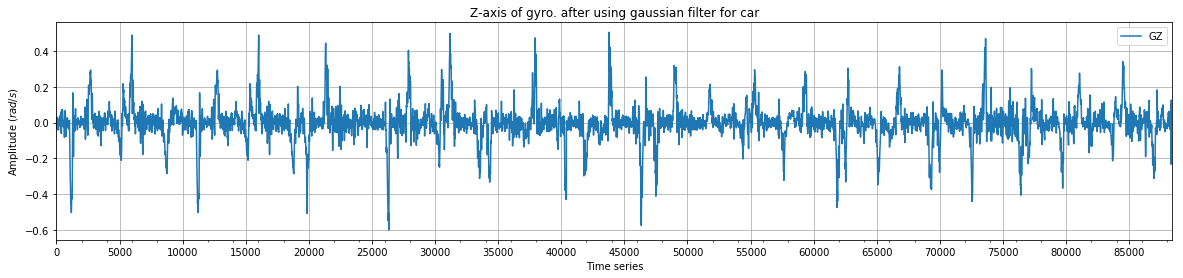

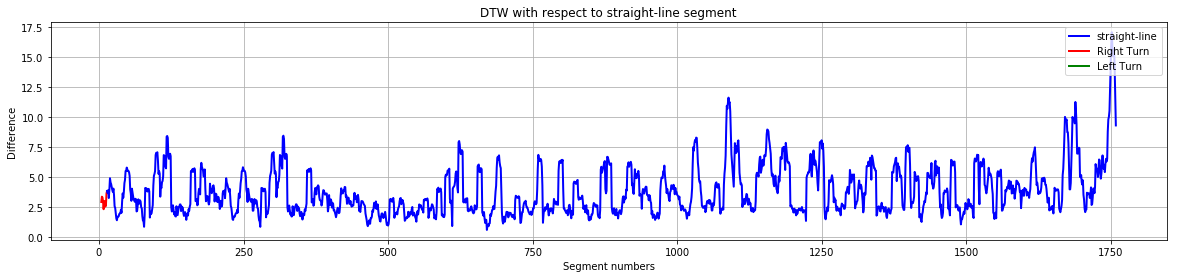

In [222]:
loss_series = pd.Series(diff_wrt_LT)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2000)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series

x = np.arange(len(y))

bike_colors = color_mapping(bike_labels)
bike_colors
plot_multicolored_lines(x,y,bike_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

In [129]:
x = bike_segments
dist_fun = manhattan_distances
y = bike_segments[10][1]
# dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
diff_wrt_LT = loss_for_segments(x, y ,dist_fun)
loss_series = pd.Series(diff_wrt_LT)
loss_series.to_csv('fiff_wrt_LT_car')

0 => 0.0575037669891
1 => 0.0605245243367
2 => 0.0614147330942
3 => 0.0606180861465
4 => 0.0508897097474
5 => 0.0605755714038
6 => 0.0558979624631
7 => 0.0559191560824
8 => 0.0410184328907
9 => 0.0412646296579
10 => 0.0
11 => 0.0239404767082
12 => 0.0457610495956
13 => 0.0529443203645
14 => 0.0506626450246
15 => 0.0602053735522
16 => 0.0577019068871
17 => 0.0547470665914
18 => 0.0850990466001
19 => 0.0700974122529
20 => 0.0729615888226
21 => 0.0823666123274
22 => 0.0759269855454
23 => 0.061038728228
24 => 0.0624811548465
25 => 0.0651736528449
26 => 0.0764878368025
27 => 0.0609546034156
28 => 0.0677164985359
29 => 0.0559215531181
30 => 0.0503106753509
31 => 0.0351103107154
32 => 0.0462329573871
33 => 0.0464145232419
34 => 0.0614128915947
35 => 0.0478205335881
36 => 0.0483739832576
37 => 0.0547236865438
38 => 0.0468624333389
39 => 0.0491553581211
40 => 0.063508717094
41 => 0.0465260374177
42 => 0.055335965805
43 => 0.0676026750418
44 => 0.0575479780691
45 => 0.0602431193034
46 => 0.06108

365 => 0.144090103622
366 => 0.152203751634
367 => 0.159769677683
368 => 0.0727297780936
369 => 0.0607398682251
370 => 0.0697701828567
371 => 0.0500664233717
372 => 0.0558054817504
373 => 0.0634197916192
374 => 0.0687942290754
375 => 0.0646503148823
376 => 0.0658675597689
377 => 0.0774661620261
378 => 0.0623786868279
379 => 0.0650333965595
380 => 0.069591810847
381 => 0.0564716876257
382 => 0.0642726041224
383 => 0.046376113384
384 => 0.0494766597722
385 => 0.0572984932692
386 => 0.0507519384525
387 => 0.0578538756499
388 => 0.0589467914418
389 => 0.058993624287
390 => 0.0635860551698
391 => 0.0663670911784
392 => 0.0645958475625
393 => 0.0721247255167
394 => 0.0777323297879
395 => 0.0566704782175
396 => 0.0537981068494
397 => 0.0576374414621
398 => 0.0517236704927
399 => 0.0442333068194
400 => 0.0534047320714
401 => 0.0503435805828
402 => 0.0498531969919
403 => 0.0486193358047
404 => 0.0515297155621
405 => 0.0627557075856
406 => 0.060888030624
407 => 0.0511429583379
408 => 0.050869086

725 => 0.0753452097425
726 => 0.0759985698342
727 => 0.0835698950357
728 => 0.081041178672
729 => 0.0529514475484
730 => 0.0527408860165
731 => 0.0434932828616
732 => 0.0426301168131
733 => 0.0494713034166
734 => 0.0510081519804
735 => 0.0424807388679
736 => 0.0592244049959
737 => 0.0643663145032
738 => 0.0683762503008
739 => 0.0590628132817
740 => 0.0580360950534
741 => 0.0527490999084
742 => 0.052328240996
743 => 0.0581164735817
744 => 0.0527516521411
745 => 0.0510777765997
746 => 0.043880524242
747 => 0.0371909545572
748 => 0.0544729452566
749 => 0.0532473328547
750 => 0.0538588853669
751 => 0.0444083313677
752 => 0.0573908380698
753 => 0.0565374215791
754 => 0.0680423199255
755 => 0.0560150022324
756 => 0.0463458419023
757 => 0.0475907378017
758 => 0.0498677375448
759 => 0.0755044602418
760 => 0.117098461313
761 => 0.111132070966
762 => 0.102381271934
763 => 0.109604858462
764 => 0.10549811701
765 => 0.12310272731
766 => 0.11567327405
767 => 0.0962260315309
768 => 0.0550283511613
7

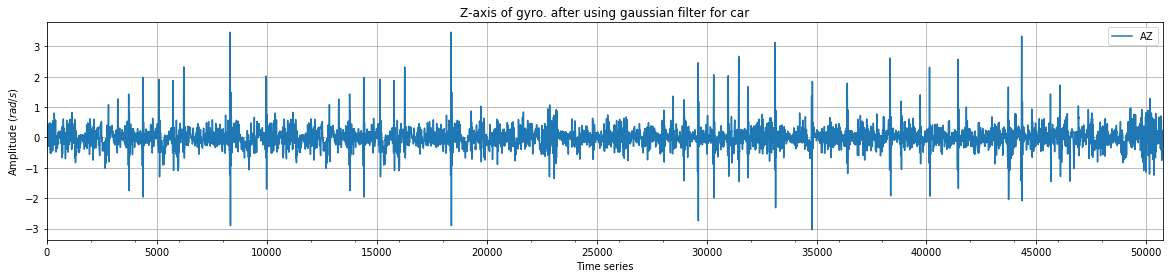

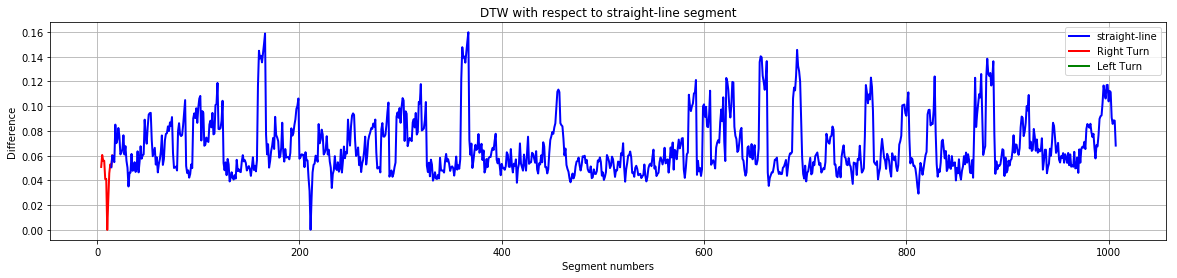

In [130]:
fig, ax = plt.subplots()
df[['AZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2000)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series
x = np.arange(len(y))
bike_colors = color_mapping(bike_labels)
plot_multicolored_lines(x,y,bike_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

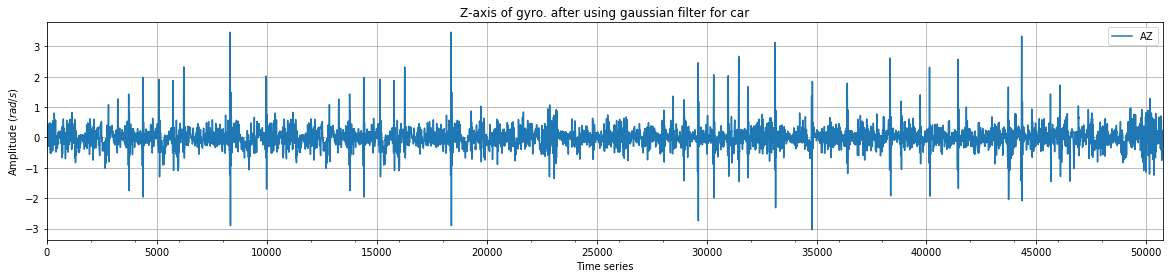

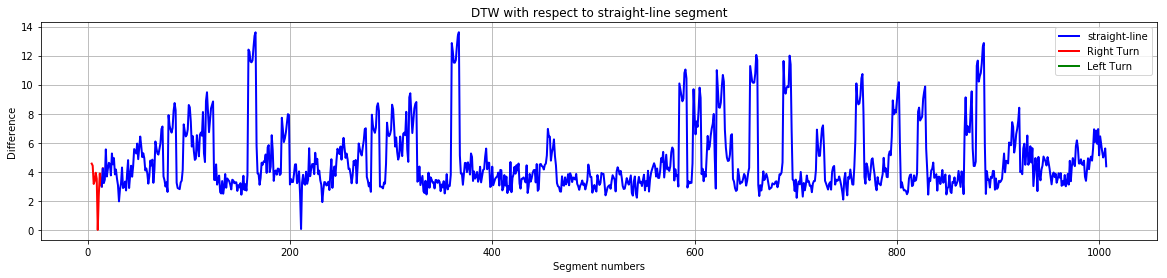

In [ ]:
x = bike_segments
dist_fun = manhattan_distances
y = bike_segments[10][1]
# dist, cost, acc, path = dtw(x, y, dist=lambda x, y: norm(x - y, ord=1))
diff_wrt_LT = loss_for_segments(x, y ,dist_fun)
loss_series = pd.Series(diff_wrt_LT)
loss_series.to_csv('fiff_wrt_LT_car')


In [ ]:
fig, ax = plt.subplots()
df[['AZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
n = len(df)
major_ticks = np.arange(0, n, 5000)
minor_ticks = np.arange(0, n, 2000)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series
x = np.arange(len(y))
bike_colors = color_mapping(bike_labels)
plot_multicolored_lines(x,y,bike_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW with respect to straight-line segment")
plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

NameError: name 'segments' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)